## Fashion-MNIST Classification: Visualizing the Machine Learning Pipeline

**Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from torchview import draw_graph
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Data Exploration**  
- Load the Fashion-MNIST dataset

In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [03:10<00:00, 138799.22it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 102405.03it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:17<00:00, 248050.28it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [5]:
classes = train_data.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

**Visualize random images from the dataset with labels as a grid using subplots**

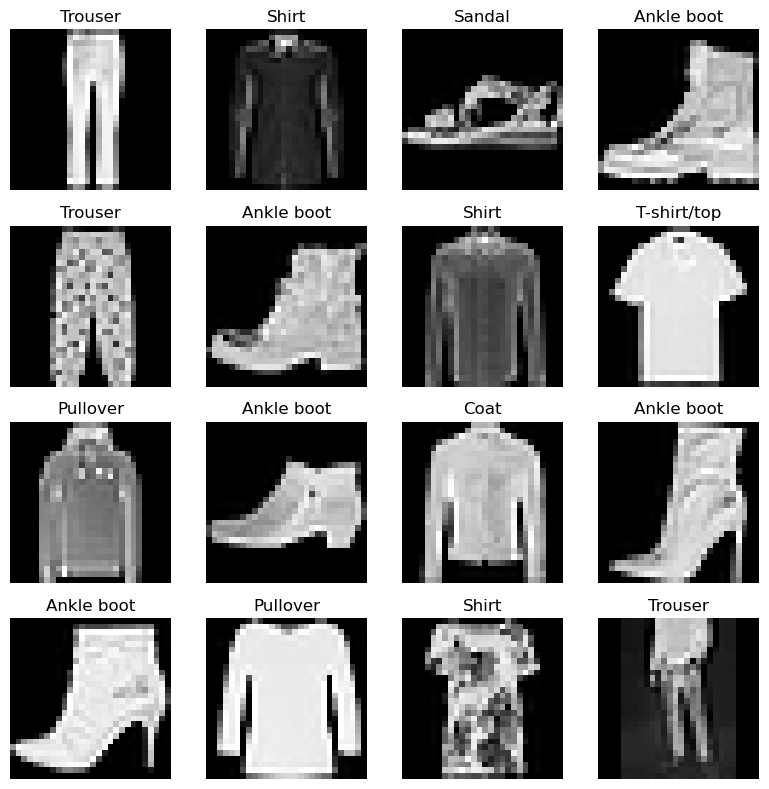

In [6]:
def show_images(data_loader, classes, num_images=16):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_loader, classes)

**Plot the class distribution of images in train data using a bar chart**

c:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


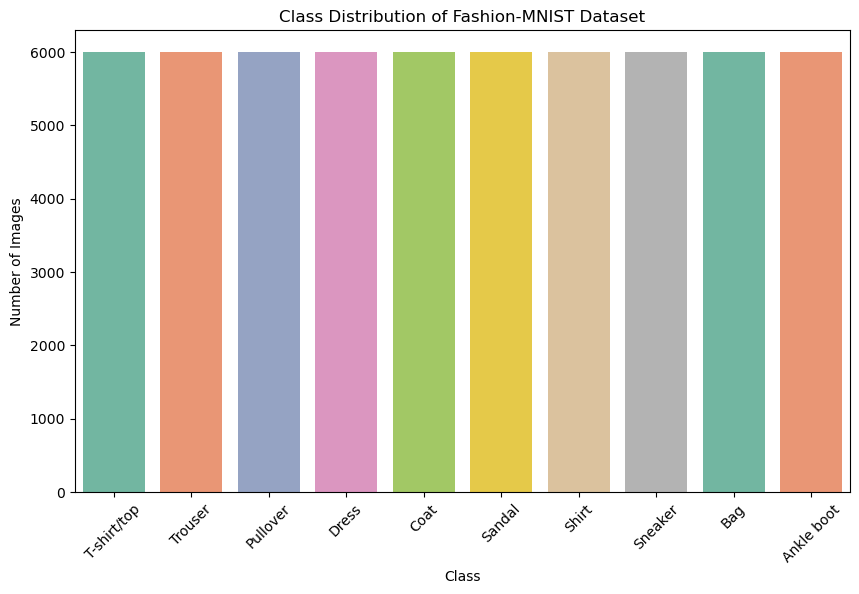

In [7]:
# Count occurrences of each class
class_counts = np.bincount([label for _, label in train_data])

plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_counts, palette="Set2")
plt.title("Class Distribution of Fashion-MNIST Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

**CNN Model**

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

**Visualize Model Architecture using `torchview`**


(process:10484): Pango-WARNING **: 13:53:23.298: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


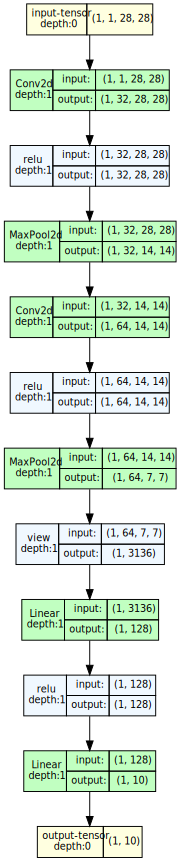

In [9]:
graph = draw_graph(model, input_size=(1, 1, 28, 28), expand_nested=True, device=device)
graph.visual_graph

**Training the Model and Visualize Training Progress**

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss, correct = 0, 0

    # Training loop with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(correct / len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_losses.append(val_loss / len(test_loader.dataset))
    val_accuracies.append(correct / len(test_loader.dataset))

    # epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/20


Epoch 1/20, Train Loss: 0.4584, Val Loss: 0.3302
Epoch 2/20


Epoch 2/20, Train Loss: 0.2904, Val Loss: 0.2882
Epoch 3/20


Epoch 3/20, Train Loss: 0.2496, Val Loss: 0.2596
Epoch 4/20


Epoch 4/20, Train Loss: 0.2194, Val Loss: 0.2505
Epoch 5/20


Epoch 5/20, Train Loss: 0.1973, Val Loss: 0.2396
Epoch 6/20


Epoch 6/20, Train Loss: 0.1766, Val Loss: 0.2308
Epoch 7/20


Epoch 7/20, Train Loss: 0.1590, Val Loss: 0.2248
Epoch 8/20


Epoch 8/20, Train Loss: 0.1410, Val Loss: 0.2450
Epoch 9/20


Epoch 9/20, Train Loss: 0.1222, Val Loss: 0.2377
Epoch 10/20


Epoch 10/20, Train Loss: 0.1082, Val Loss: 0.2392
Epoch 11/20


Epoch 11/20, Train Loss: 0.0931, Val Loss: 0.2420
Epoch 12/20


Epoch 12/20, Train Loss: 0.0799, Val Loss: 0.2731
Epoch 13/20


Epoch 13/20, Train Loss: 0.0682, Val Loss: 0.2730
Epoch 14/20


Epoch 14/20, Train Loss: 0.0591, Val Loss: 0.2829
Epoch 15/20


Epoch 15/20, Train Loss: 0.0513, Val Loss: 0.3250
Epoch 16/20


Epoch 16/20, Train Loss: 0.0418, Val Loss: 0.3365
Epoch 17/20


Epoch 17/20, Train Loss: 0.0397, Val Loss: 0.3734
Epoch 18/20


Epoch 18/20, Train Loss: 0.0323, Val Loss: 0.3713
Epoch 19/20


Epoch 19/20, Train Loss: 0.0308, Val Loss: 0.3895
Epoch 20/20


Epoch 20/20, Train Loss: 0.0256, Val Loss: 0.4258


**Learning Curves (training vs. Validation Loss)**

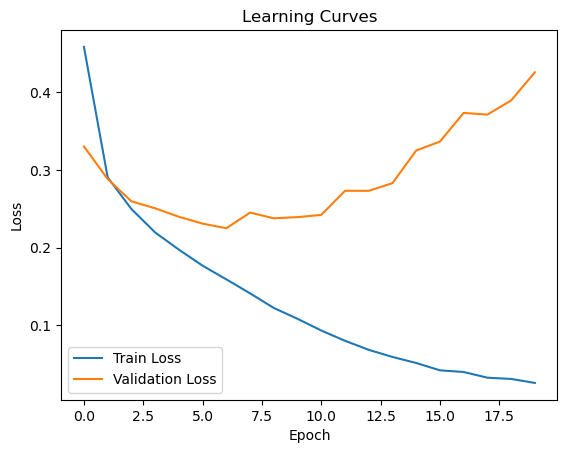

In [12]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

**Accuracy Curves (training vs. validatin accuracy)**

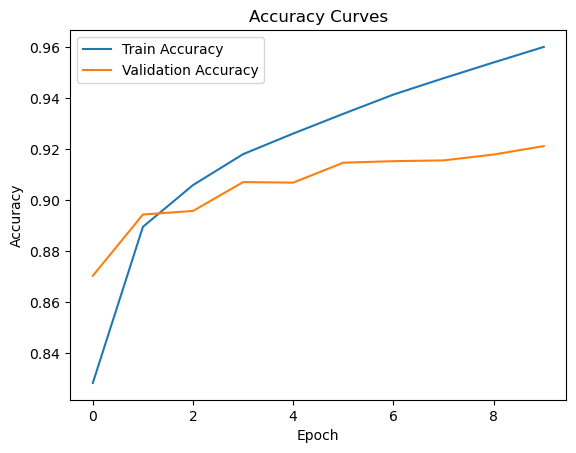

In [14]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

**Evaluate the Model on Test Data**
- Plot the confusion matrix with a heatmap

Test Accuracy: 91.95%


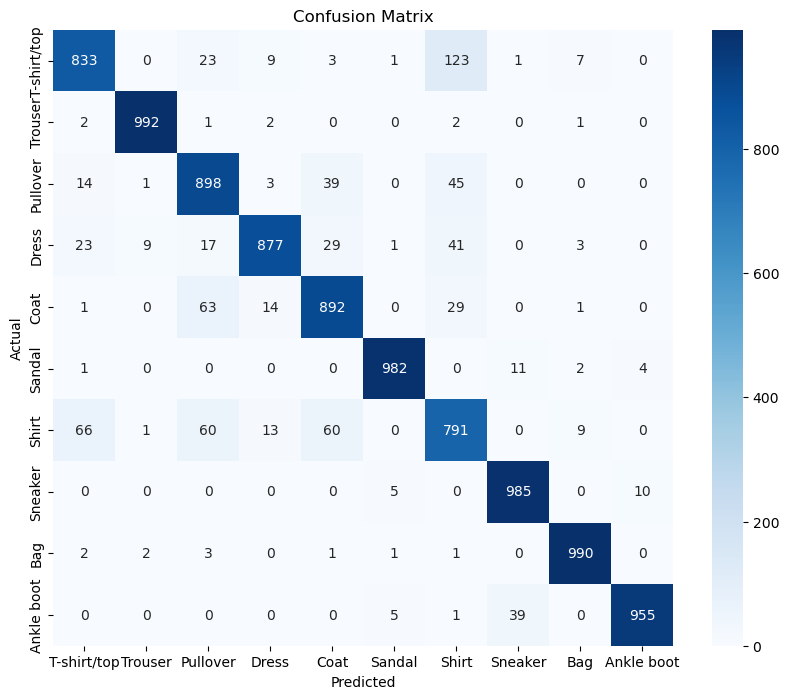

In [13]:
# Get predictions and true labels
y_pred, y_true = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy on test data
test_accuracy = sum(np.array(y_pred) == np.array(y_true)) / len(y_true)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---

**Model Retraining with Preprocessed Data**  
- Apply normalization and train again

In [14]:
# transforms with normalization
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Reload datasets with normalization
train_data_norm = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_norm)
test_data_norm = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_norm)

In [15]:
train_loader_norm = DataLoader(train_data_norm, batch_size=64, shuffle=True)
test_loader_norm = DataLoader(test_data_norm, batch_size=64, shuffle=False)

In [16]:
train_losses_norm, val_losses_norm = [], []
train_accuracies_norm, val_accuracies_norm = [], []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss, correct = 0, 0

    # Training loop with tqdm progress bar
    for images, labels in tqdm(train_loader_norm, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        
    train_losses_norm.append(train_loss / len(train_loader_norm.dataset))
    train_accuracies_norm.append(correct / len(train_loader_norm.dataset))

    # Validation loop
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader_norm, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            
    val_losses_norm.append(val_loss / len(test_loader_norm.dataset))
    val_accuracies_norm.append(correct / len(test_loader_norm.dataset))
    
    # epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 2/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 3/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 4/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 5/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 6/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 7/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 8/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 9/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 10/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 11/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 12/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 13/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 14/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 15/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 16/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 17/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 18/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 19/20, Train Loss: 0.0256, Val Loss: 0.4258


Epoch 20/20, Train Loss: 0.0256, Val Loss: 0.4258


**Learning Curves  - Training vs. Validation loss**

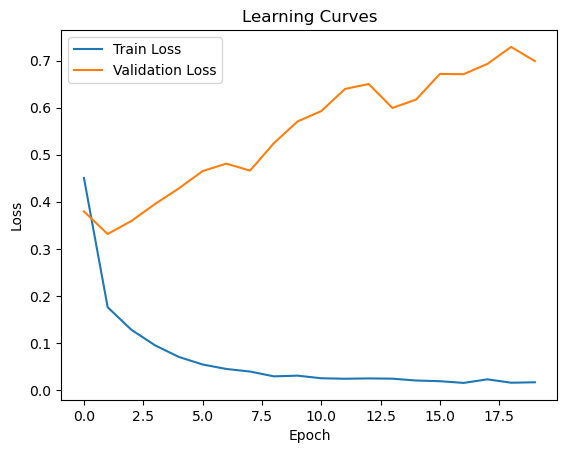

In [17]:
plt.plot(train_losses_norm, label='Train Loss')
plt.plot(val_losses_norm, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

**Accuracy curves - Training vs. Validatin Accuracy**

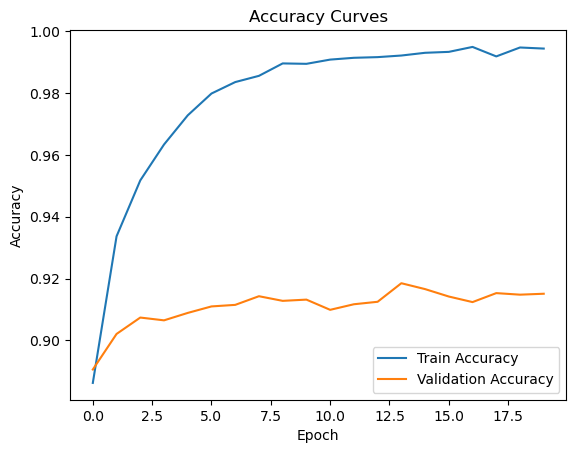

In [18]:
plt.plot(train_accuracies_norm, label='Train Accuracy')
plt.plot(val_accuracies_norm, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

**Evaluate the Model on Test Data**
- Plot the confusion matrix with a heatmap

Test Accuracy: 91.51%


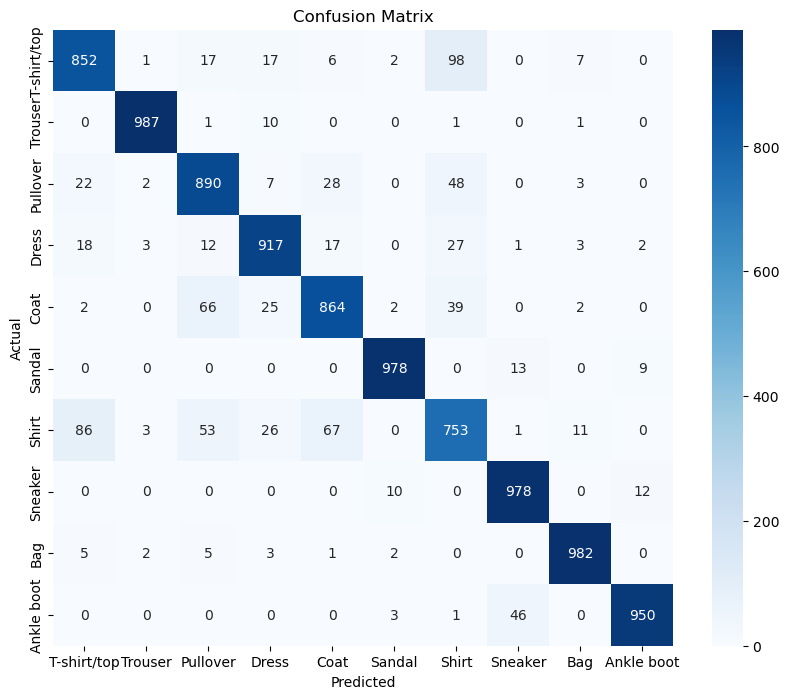

In [19]:
# Get predictions and true labels
y_pred, y_true = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader_norm:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy on test data
test_accuracy_norm = sum(np.array(y_pred) == np.array(y_true)) / len(y_true)
print(f"Test Accuracy: {test_accuracy_norm * 100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Compare Accuracy Before and After Preprocessing**

c:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


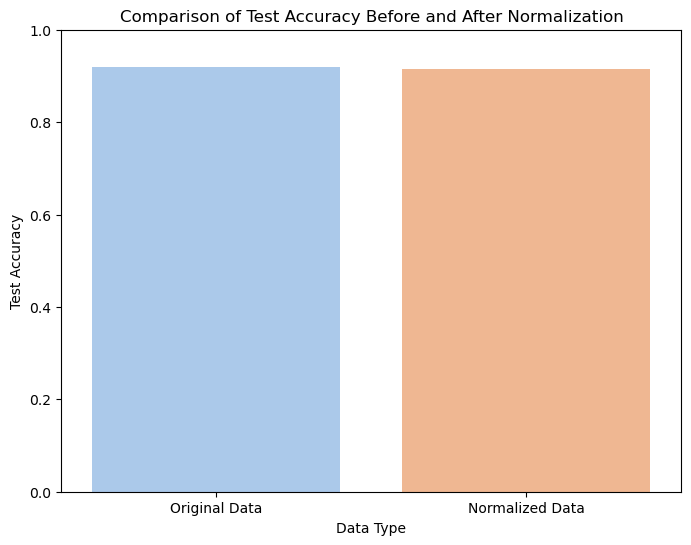

In [20]:
# Assuming `test_accuracy` and `test_accuracy_norm` hold the test accuracies
accuracies = [test_accuracy, test_accuracy_norm]
labels = ['Original Data', 'Normalized Data']

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=accuracies, palette="pastel")
plt.title("Comparison of Test Accuracy Before and After Normalization")
plt.xlabel("Data Type")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.show()

---